In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

## DeepWalk

In [ ]:
import deepwalk
from deepwalk import graph
from deepwalk import walks as serialized_walks
from gensim.models import Word2Vec
from deepwalk.skipgram import Skipgram
import dataset_helper
import graph_helper
import random
from gensim.models import Word2Vec
import tsne
import matplotlib.pyplot as plt

max_memory_data_size = 1000000000
number_walks = 1000
representation_size = 64
seed = 0
undirected = True
vertex_freq_degree = False
walk_length = 60
window_size = 10
workers = 1
output = 'data/DUMP'

for dataset in dataset_helper.get_all_available_dataset_names():
    cache_file = dataset_helper.CACHE_PATH + '/dataset_graph_cooccurrence_{}.npy'.format(dataset)
    X, Y = dataset_helper.get_dataset(dataset, preprocessed = False, use_cached=True, transform_fn=graph_helper.convert_dataset_to_co_occurence_graph_dataset, cache_file=cache_file)
    break
    
models = []
for idx, g in enumerate(X):
    if idx == 3: break
    print('Graph: {:>4}'.format(idx))
    G = graph.from_networkx(g)

    print("Number of nodes: {}".format(len(G.nodes())))
    if len(G.nodes()) == 0:
        continue

    num_walks = len(G.nodes()) * number_walks

    print("Number of walks: {}".format(num_walks))

    data_size = num_walks * walk_length

    print("Data size (walks*length): {}".format(data_size))

    print("Walking...")
    walks = graph.build_deepwalk_corpus(G, num_paths=number_walks, path_length=walk_length, alpha=0, rand=random.Random(seed))
    print("Training...")
    model = Word2Vec(walks, size=representation_size, window=window_size, min_count=0, workers=workers)

    #model.wv.save_word2vec_format(output)
    models.append(model)
print('Finished')

## tSNE

In [ ]:
for model in models:
    print('Next')
    vectors = tsne.get_tsne_embedding(model)
    tsne.plot_embedding(model, vectors)
    plt.show()

## Test WL phi computation

In [ ]:
if 0 == 1:
    for i, (a, b) in enumerate(zip(phi_1_2_3_test, phi_1_2_3)):
        if not np.array_equiv(a - b.todense(), np.zeros(b.shape, dtype = np.int32)):
            print("\tPhi different! {}".format(i))
            print(np.argwhere((a - b) != 0))

    for i, (a, b) in enumerate(zip(K_1_2_3_test, K_1_2_3)):
        if not np.array_equal(a, b):
            print(np.argwhere((a - b) != 0))
            print("\tK different! {}".format(i))

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

num_labels = len(labels)

for (n, treshold), lookup in results.items():
    cliques = coreference.get_cliques_from_lookup(lookup)
    similarity_counter = {'similar': len(lookup.keys()), 'unsimilar': num_labels - len(lookup.keys())}
    clique_lenghts = [len(x) for x in list(cliques.values())]
    fig, axes = plt.subplots(1, 2, figsize = (14, 6))
    fig.suptitle('Treshold: {}, N={}'.format(treshold, n), fontsize = 16)

    pd.DataFrame(clique_lenghts).plot(ax = axes[0], kind = 'hist', logy = True, legend = False, title = "Histogram of clique lengths".format(treshold))
    pd.DataFrame(list(similarity_counter.items()), columns = ['name', 'count']).set_index('name').plot(ax = axes[1], kind = 'bar', legend = False, title = '# of labels that have been merged vs. not merged')
    fig.tight_layout()
    fig.subplots_adjust(top=0.85)
    fig.savefig('tmp/{:.5f}.{}.png'.format(treshold, n), dpi = 120)
    plt.close(fig)

In [ ]:
sns.set('notebook', 'white')
def plot_by(df, by, bins = 15, title = '', figsize = (12, 5), fontsize = 16):
    fig, ax = plt.subplots(figsize = figsize)

    data = []
    labels = []
    for n, vals in df.groupby(by):
        labels.append(n)
        data.append(vals.clique_length)
    ax.hist(data, bins = bins, alpha=0.7, label=labels, log = True)
    fig.suptitle(title, fontsize = fontsize)
    ax.legend(loc='upper right', fontsize = fontsize)
    ax.set_xlabel('clique sizes')
    fig.tight_layout()
    fig.subplots_adjust(top=0.9)
    return fig, ax
fig, ax = plot_by(df, 'n', title = 'Clique size histogram by n (all thresholds together)')
fig.savefig('tmp/clique_size_by_n_all_thresholds.png', dpi = 120)
fig, ax = plot_by(df, 'threshold', title = 'Clique size histogram by threshold (all n together)')
fig.savefig('tmp/clique_size_by_threshold_all_n.png', dpi = 120)
fig, ax = plot_by(df[df.threshold == 0.6], 'n', title = 'Clique size histogram by n (threshold=0.6)')
fig.savefig('tmp/clique_size_by_n_threshold_0.6.png', dpi = 120)
plt.show()

In [ ]:
import dataset_helper
import pickle
import numpy as np
import sklearn
graph_cache_file = 'dataset_graph_gml_ng20-single.npy'
X, Y = dataset_helper.get_dataset_cached('data/CACHE/{}'.format(graph_cache_file))
X, Y = np.array(X, dtype=object), np.array(Y, dtype=object)
sss = sklearn.model_selection.StratifiedShuffleSplit(n_splits = 20, random_state=42)
for train_index, test_index in sss.split(X, Y):
    X_test, Y_test = X[test_index], Y[test_index]
    break
with open('data/CACHE/dataset_graph_gml_small-single.npy', 'wb') as f:
    pickle.dump((X_test.tolist(), Y_test.tolist()), f)    

In [ ]:
import dataset_helper
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns

sns.set('notebook', 'white')
limit_dataset = ['ng20', 'ling-spam', 'reuters-21578', 'webkb']
#limit_dataset = ['ling-spam']
all_stats = {}
for dataset_name in dataset_helper.get_all_available_dataset_names():
    if dataset_name not in limit_dataset: continue
    print(dataset_name)
    X, Y = dataset_helper.get_dataset(dataset_name)
    graphs = dataset_helper.get_all_cached_graph_datasets(dataset_name)
    number_of_nodes = []
    
    coo_graph = [x for x in graphs if 'cooccurrence' in x][0]
    gml_graph = [x for x in graphs if 'gml' in x][0]
    
    def get_num_nodes(graph_file):
        X_graph, _ = dataset_helper.get_dataset_cached(graph_file)
        return [nx.number_of_nodes(x) for x in X_graph]
    
    stats = {
        'cooccurrence': get_num_nodes(coo_graph),
        'concept-graphs': get_num_nodes(gml_graph)
    }
    min_len = min([len(v) for k, v in stats.items()])
    graph_stats = {k: v[:min(min_len, len(v))] for k, v in stats.items()}
    df = pd.DataFrame(graph_stats)
    figsize = (12, 4)
    fig, ax = plt.subplots(nrows = 1, ncols=2, figsize = figsize)
    colors = reversed(["orangered", "royalblue"])
    colors = None
    df.plot(kind = 'hist', alpha = 0.7, bins=20, logy = True, color=colors, ax=ax[0])
    ax[0].set_xlabel('# nodes per graph')
    
    text_stats = {'doc_lengths': [len(x) for x in X]}
    df = pd.DataFrame(text_stats)
    df.plot(kind = 'hist', bins=20, legend = False, logy = True, ax=ax[1], color = 'royalblue')
    ax[1].set_xlabel('# characters per document')
    plt.show()
    fig.savefig('tmp/other/stats-{}.png'.format(dataset_name), dpi = 150)
    all_stats[dataset_name] = {
        'graphs': graph_stats,
        'text': text_stats['doc_lengths'],
        'num_docs': len(X),
        'num_classes': len(set(Y))
    }


In [ ]:
import numpy
out = []
for dataset, stats in all_stats.items():
    out.append((dataset, np.mean(stats['text']), np.mean(stats['graphs']['cooccurrence']), np.mean(stats['graphs']['concept-graphs']), stats['num_docs'], stats['num_classes']))
    
fig, axes = plt.subplots(nrows=3, ncols=1, figsize = (8, 5))

df = pd.DataFrame(out, columns = ['dataset', 'avg_doc_length', 'avg_coo_node_num', 'avg_cp_node_num', 'num_docs', 'num_classes'])
df = df.set_index('dataset')
#, ('# classes', 'num_classes')
for idx, (name, x) in enumerate([('Average document length', 'avg_doc_length'), ('# documents', 'num_docs'), ('Average of number of concept-graph nodes', 'avg_cp_node_num')]):
    ax = axes[idx]
    df[x].plot(kind = 'barh', logx = True, title = name, ax = ax)
fig.tight_layout()
fig.savefig('tmp/other/stats-datasets.png', dpi = 120)
plt.show()

In [ ]:
import pickle
import dataset_helper
import collections
import coreference
import matplotlib.pyplot as plt
from transformers.nx_graph_to_tuple_transformer import NxGraphToTupleTransformer

check_graphs = False

trans = NxGraphToTupleTransformer()
for dataset_name in dataset_helper.get_all_available_dataset_names():
    if dataset_name not in dataset_helper.DATASETS_LIMITED: continue
    graph_cache_files = dataset_helper.get_all_cached_graph_datasets(dataset_name)
    if not len(graph_cache_files): continue
    
    with open('data/embeddings/graph-embeddings/{}.label-lookup.npy'.format(dataset_name), 'rb') as f:
        lookup = pickle.load(f)
    
    fig, axes = coreference.plot_lookup_histogram(lookup, len(lookup.keys()))
    plt.show()
        
    counter = collections.Counter()
    all_labels = set()
    for graph_cache_file in graph_cache_files:
        X, _ = dataset_helper.get_dataset_cached(graph_cache_file)
        X = trans.transform(X)
        
        for adj, labels in X:
            all_labels |= set(labels)
            for label in labels:
                counter['found' if label in lookup and str(lookup[label]).strip() != str(label).strip() else 'not_found'] += 1
    print(counter)
    print(len(all_labels))
    fig, axes = coreference.plot_lookup_histogram(lookup, len(all_labels))
    plt.show()
    break

In [50]:
import pickle
import dataset_helper
import collections
import coreference
import matplotlib.pyplot as plt
from transformers.nx_graph_to_tuple_transformer import NxGraphToTupleTransformer
import networkx as nx

def merge_graphs(graphs):
    return nx.compose_all(graphs)

trans = NxGraphToTupleTransformer()
for dataset_name in dataset_helper.get_all_available_dataset_names():
    if dataset_name not in dataset_helper.DATASETS_LIMITED: continue
    graph_cache_files = dataset_helper.get_all_cached_graph_datasets(dataset_name)
    if not len(graph_cache_files): continue
    
    for graph_cache_file in graph_cache_files:
        if 'gml' not in graph_cache_file: continue
        
        X, Y = dataset_helper.get_dataset_cached(graph_cache_file)
        #X = trans.transform(X)
        
        num_labels = 0
        all_labels = set()
        all_labels_stripped = set()
        
        #for adj, labels in X:
        for g in X:
            labels = g.nodes()
            all_labels |= set(labels)
            all_labels_stripped |= set([str(label).strip() for label in labels])
            num_labels += len(labels)
    
    num_uniq_labels = len(all_labels)
    num_uniq_labels_stripped = len(all_labels_stripped)
    print('#labels:\t\t{}'.format(num_labels))
    print('#uniq. labels:\t\t{}'.format(num_uniq_labels))
    print('#uniq. labels stripped:\t{}'.format(num_uniq_labels_stripped))
    print('#non-uniq. labels: \t{}'.format(num_labels - num_uniq_labels))
    
    d = dataset_helper.get_dataset_dict(X, Y)
    merged = {label: merge_graphs(graphs) for label, graphs in d.items()}
    break

#labels:		57943
#uniq. labels:		38598
#uniq. labels stripped:	38592
#non-uniq. labels: 	19345


KeyboardInterrupt: 

In [3]:
import pickle
import dataset_helper
import collections
import coreference
import matplotlib.pyplot as plt
from transformers.nx_graph_to_tuple_transformer import NxGraphToTupleTransformer
from transformers.relabel_graphs_transformer import RelabelGraphsTransformer
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import coreference 
sns.set_style('white')

def get_treshold_and_topn_from_lookupfilename(filename):
    topn = filename.split('topn-')[1].split('.label')[0]
    threshold = filename.split('threshold-')[1].split('.topn')[0]
    return threshold, topn

trans = NxGraphToTupleTransformer()
for dataset_name in dataset_helper.get_all_available_dataset_names():
    #if dataset_name not in dataset_helper.DATASETS_LIMITED: continue
    if dataset_name not in ['ling-spam', 'ng20']: continue
    graph_cache_files = dataset_helper.get_all_cached_graph_datasets(dataset_name)
    if not len(graph_cache_files): continue

    for graph_cache_file in graph_cache_files:
        print('Loading dataset: Start ({})'.format(graph_cache_file))
        X_old, _ = dataset_helper.get_dataset_cached(graph_cache_file)
        print('TupleTransform: Start')
        X_old = trans.transform(X_old)
        X_labels = [labels for _, labels in X_old]
        
        lookups = glob('data/embeddings/graph-embeddings/{}.*.*.label-lookup.npy'.format(dataset_name))
        for lookup_file in lookups:
            # Load lookup
            threshold, topn = get_treshold_and_topn_from_lookupfilename(lookup_file)
            with open(lookup_file, 'rb') as f:
                lookup = pickle.load(f)
            
            # Relabel
            relabel_trans = RelabelGraphsTransformer(lookup)
            X = relabel_trans.transform(X_old)
            duplicate_labels_count = []
            different_counts = []
            for (_, labels), old_labels in zip(X, X_labels):
                labels_set = set(labels)
                different_counts.append(collections.Counter([str(l1).lower().strip() != str(l2).lower().strip() for l1, l2 in zip(labels, old_labels)])[True])
                duplicate_labels_count.append(len(labels) - len(labels_set))
            label_counters = [len(labels) for _, labels in X]
    
            df = pd.DataFrame(list(zip(different_counts, duplicate_labels_count, label_counters)), columns = ['different_count', 'duplicate_labels_count', 'label_count'])
            df['relabeled_ratio'] = df.different_count / df.label_count
            df['duplicate_ratio'] = df.duplicate_labels_count / df.label_count
            fig, ax = plt.subplots(figsize = (16, 4))
            df[['relabeled_ratio', 'duplicate_ratio']].plot(kind = 'hist', bins = 100, log = True, title = 'Histogram (threshold={}, topn={})'.format(threshold, topn), ax = ax, alpha = 0.7)
            plt.show()
            plt.close(fig)
        break


Loading dataset: Start (data/CACHE/dataset_graph_cooccurrence_1_all_ling-spam.npy)
TupleTransform: Start


KeyboardInterrupt: 

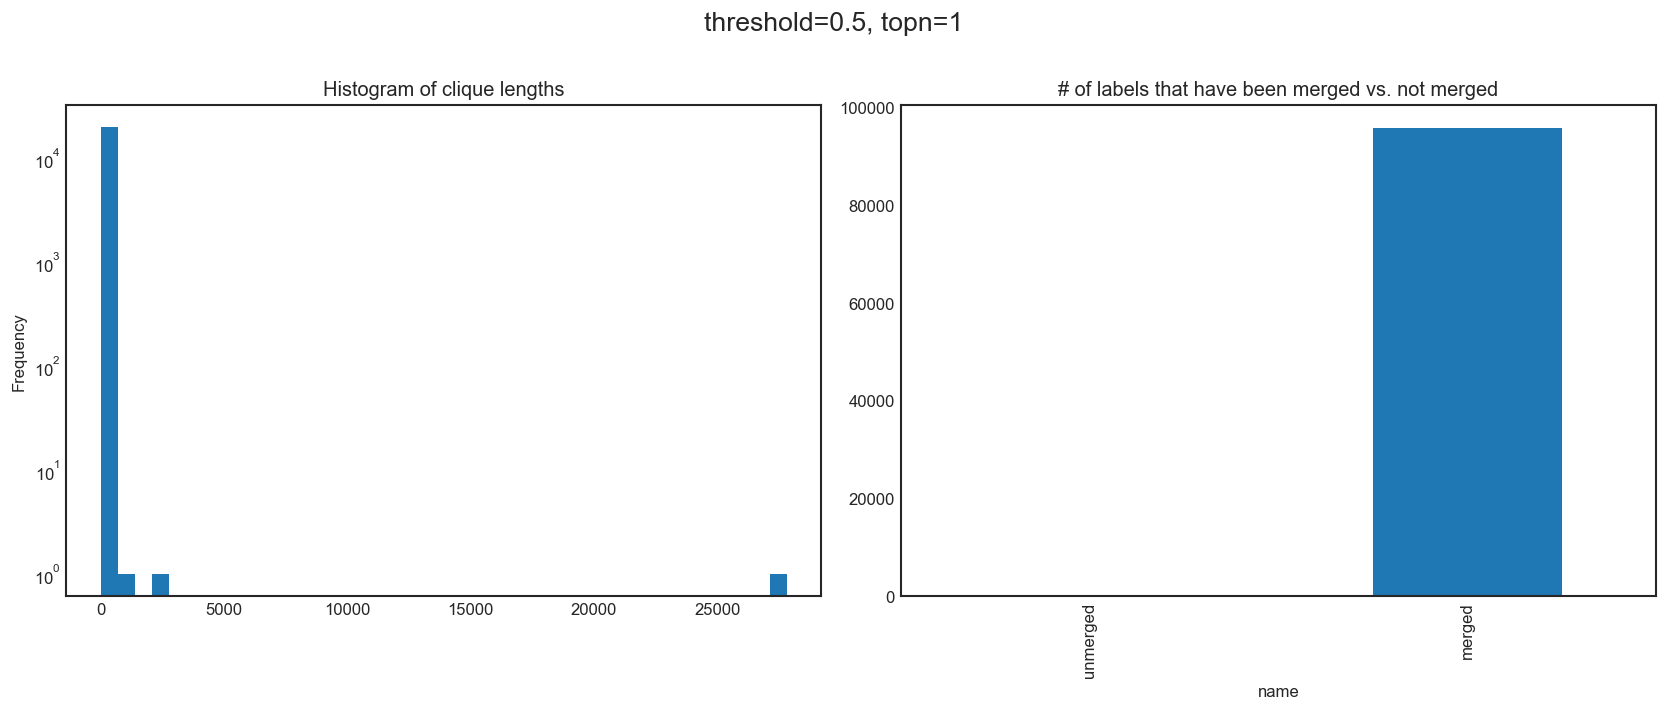

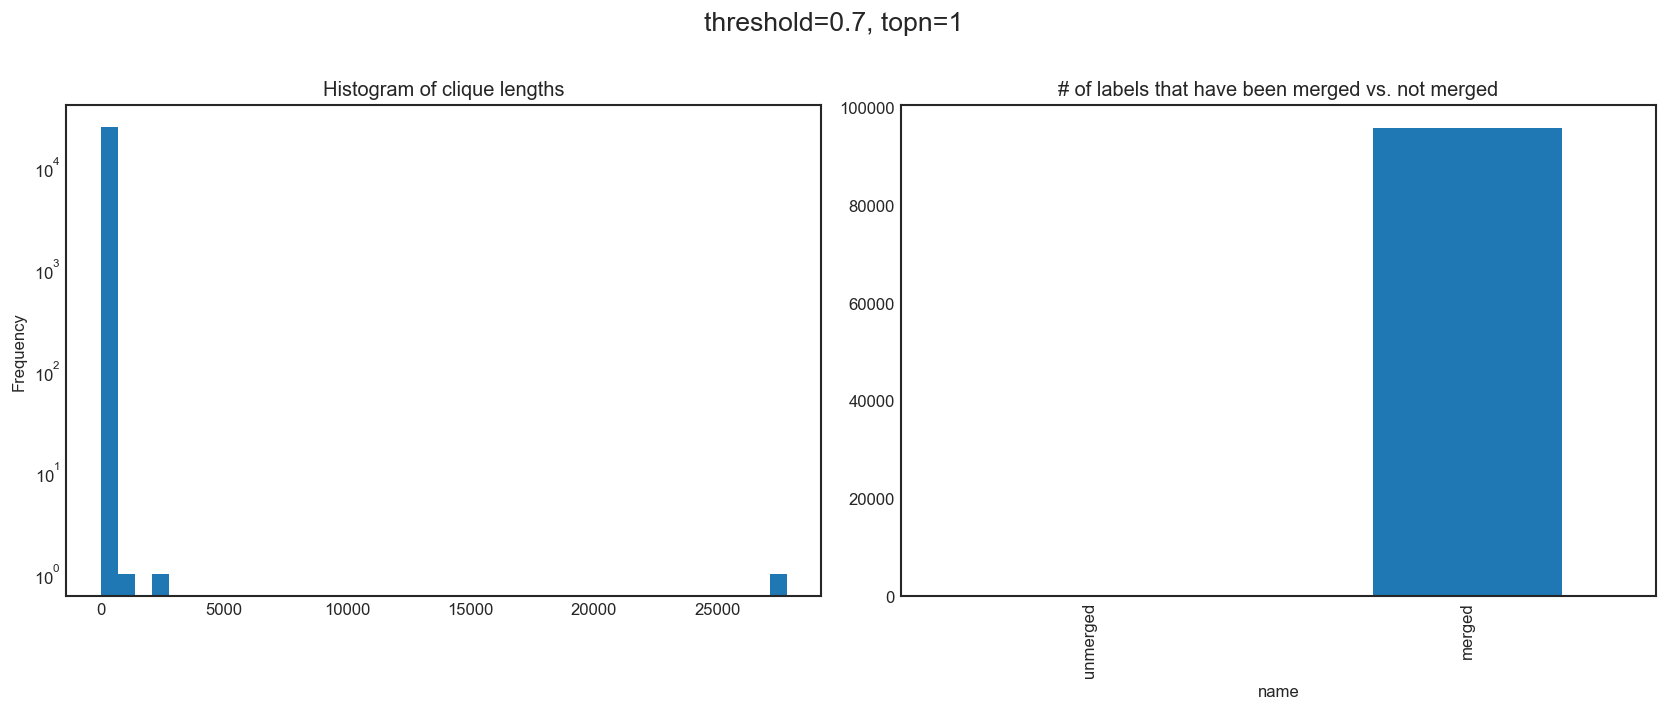

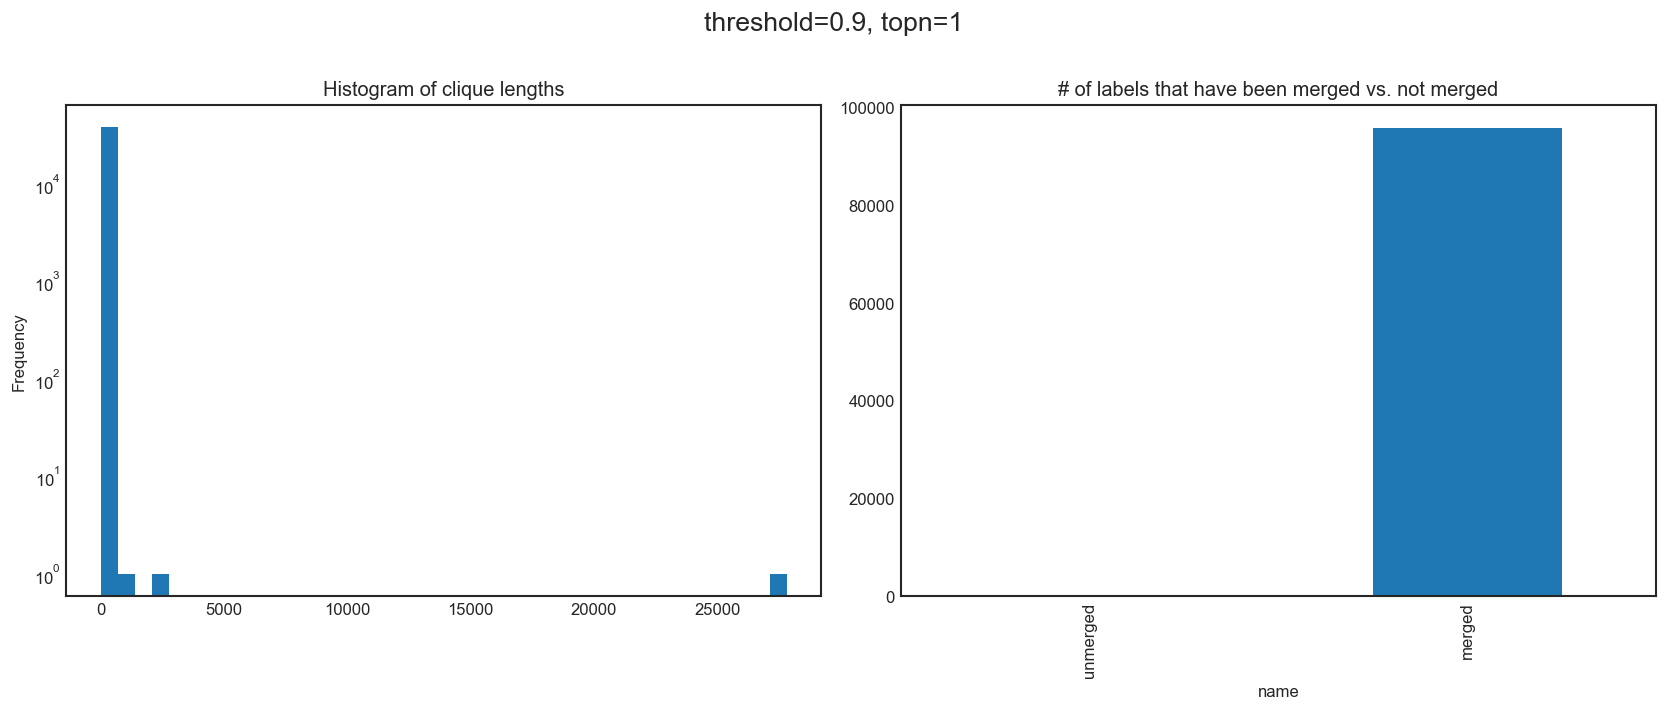

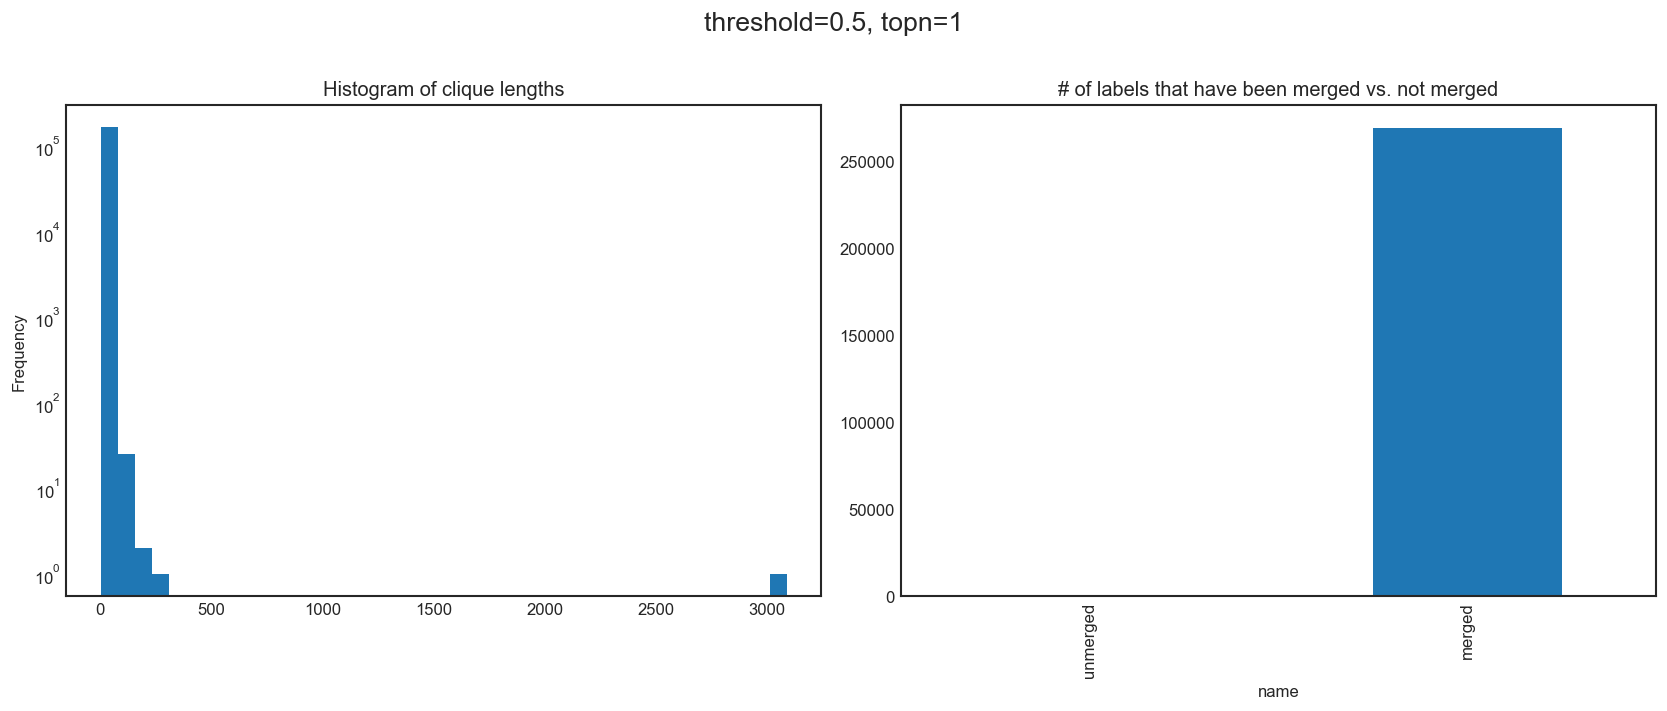

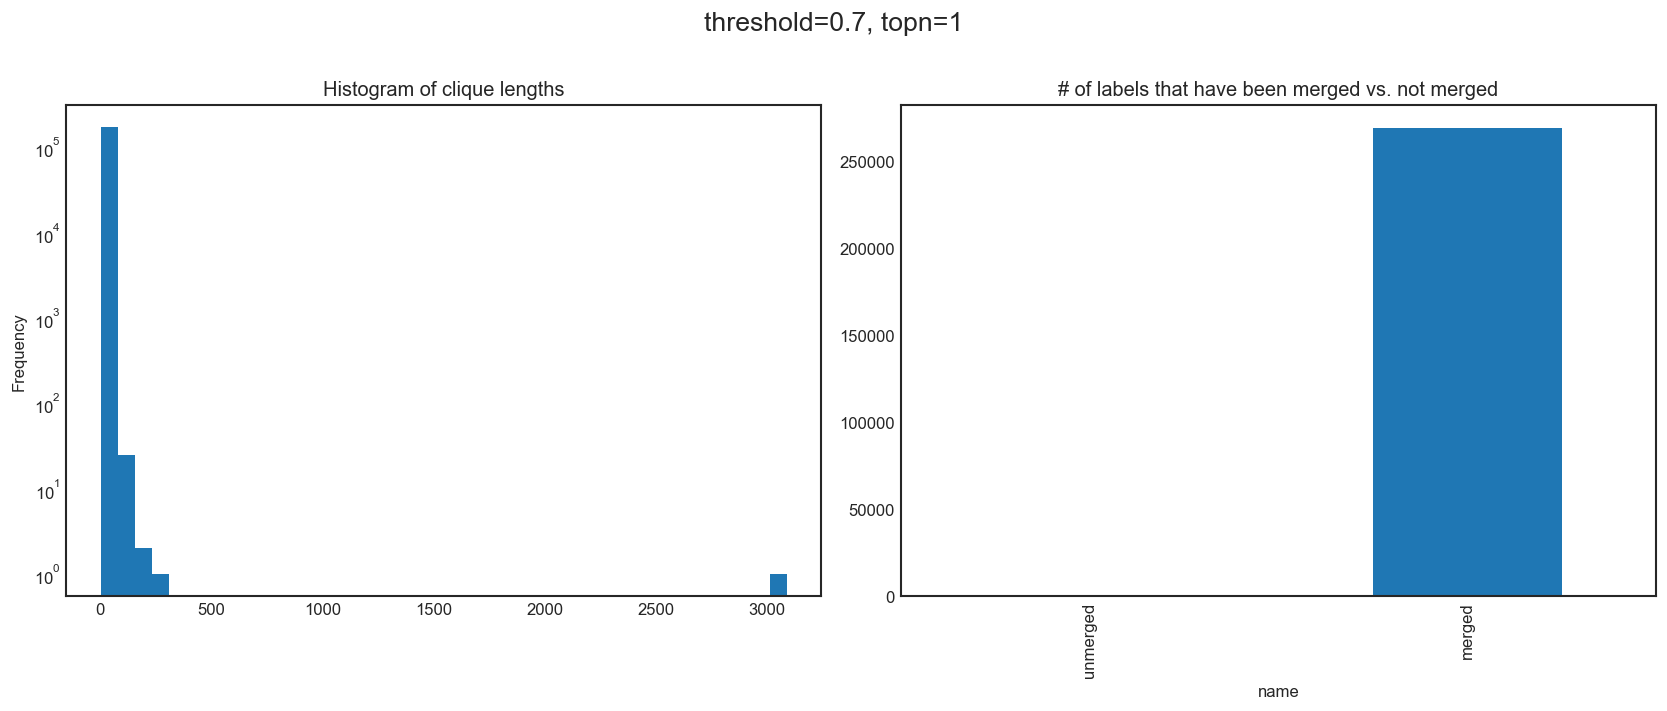

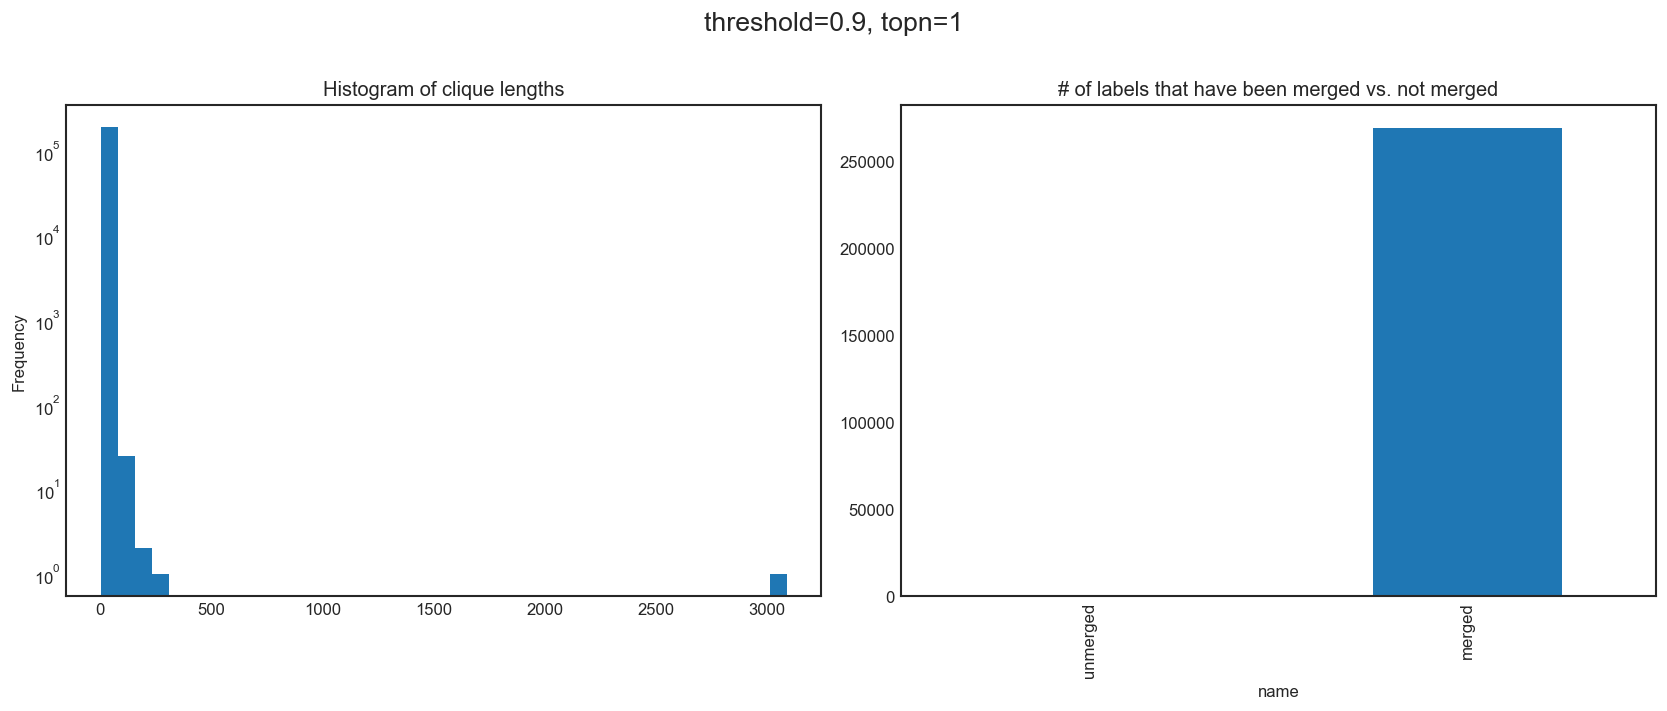

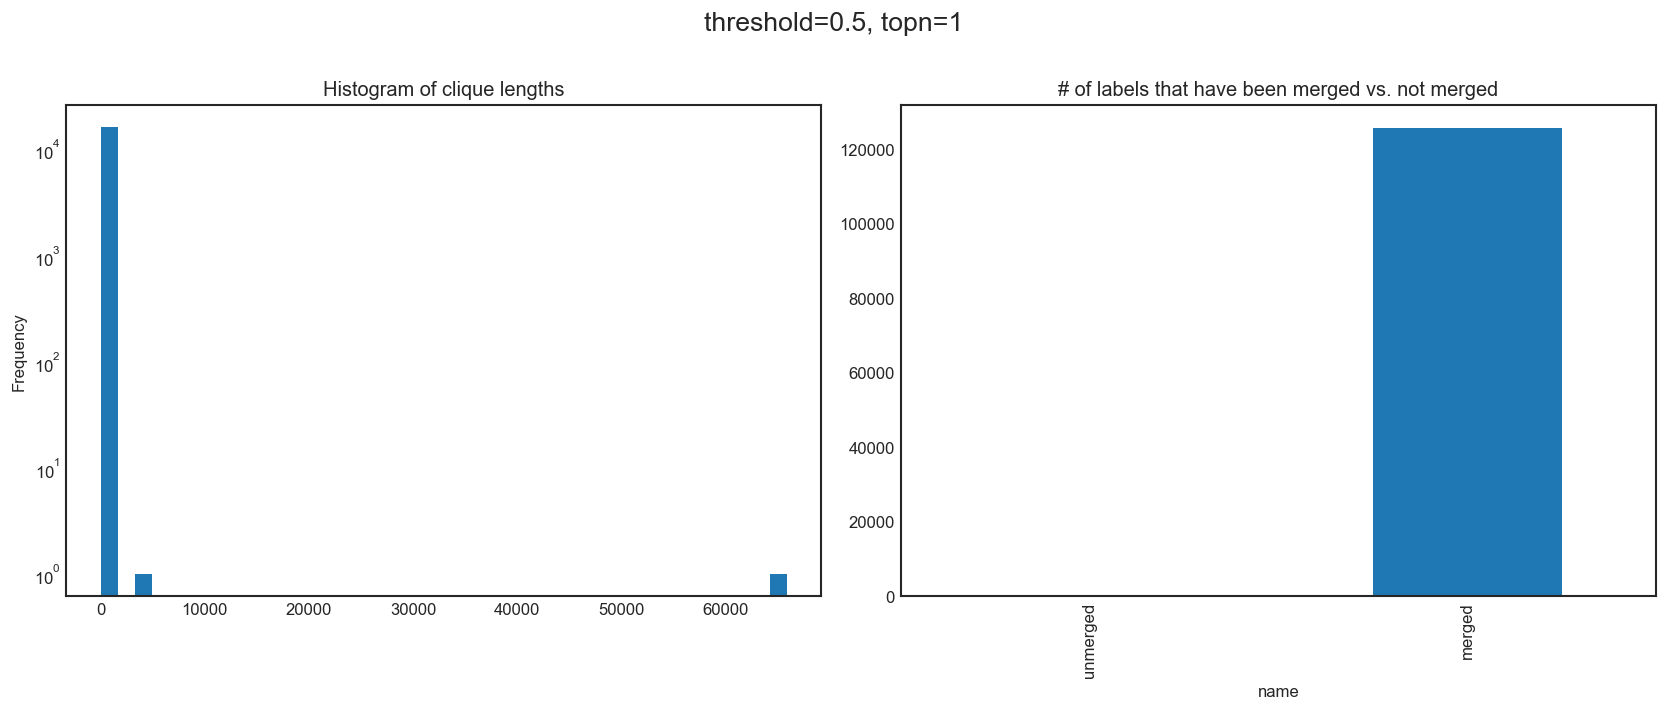

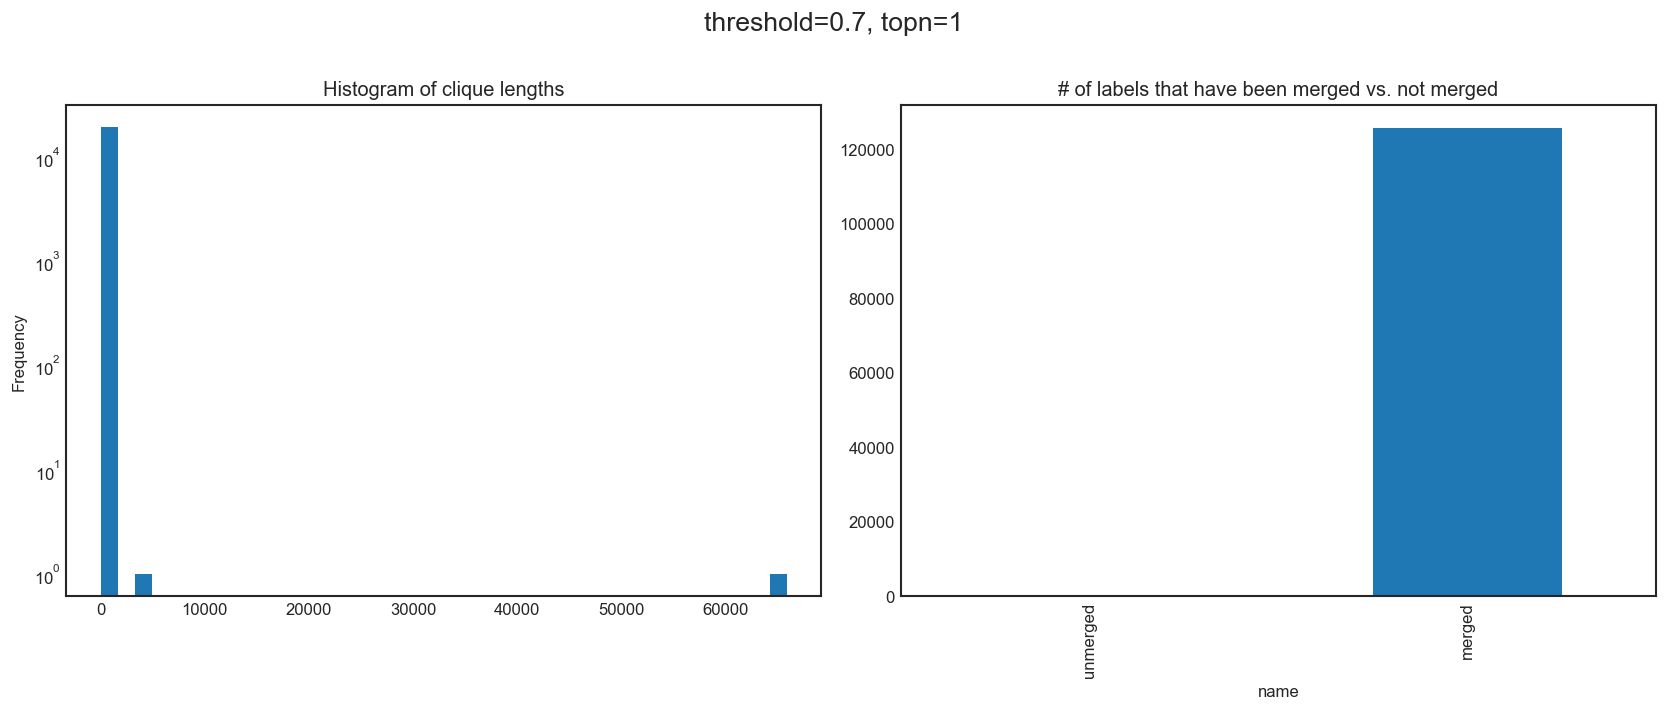

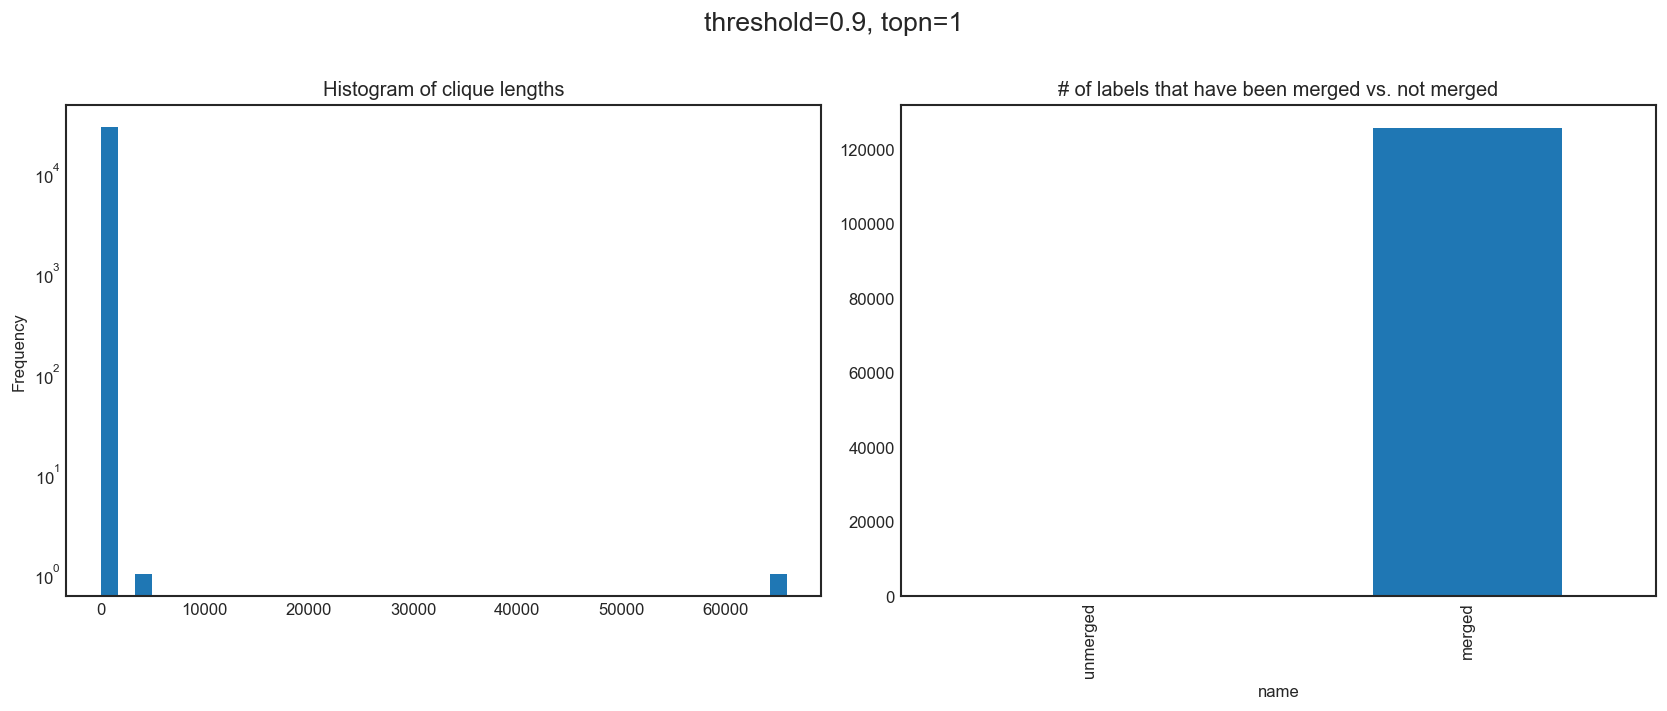

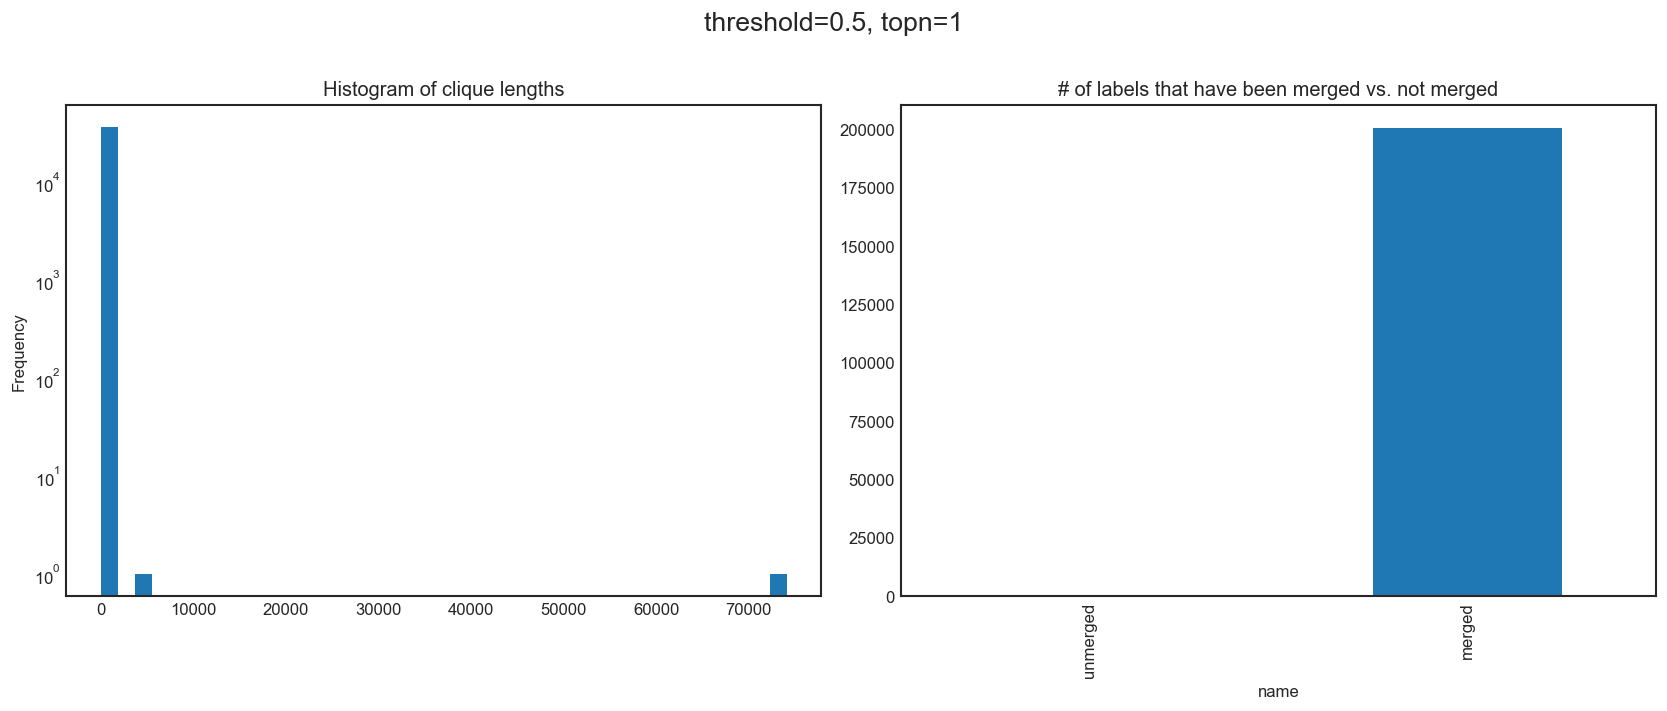

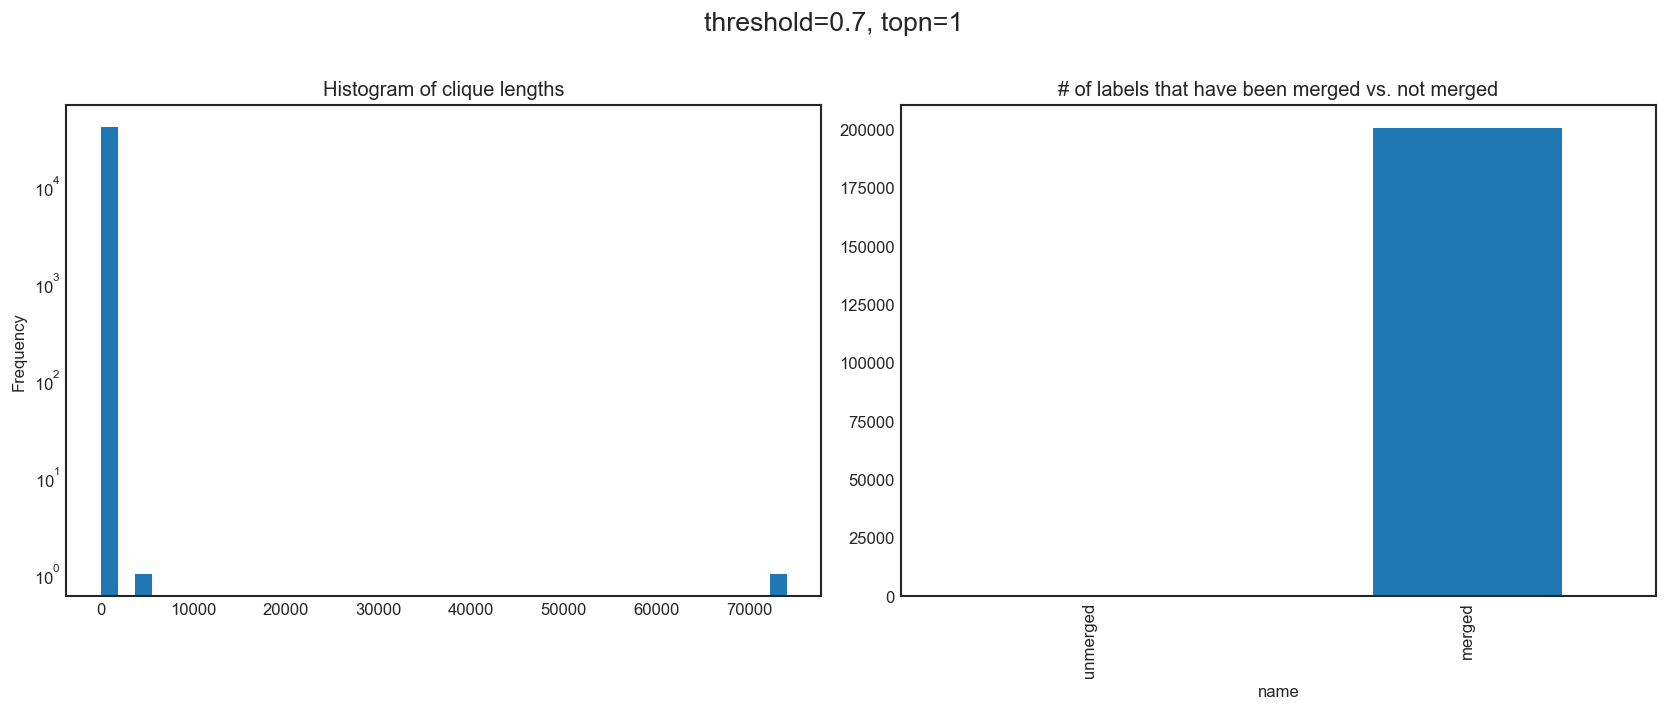

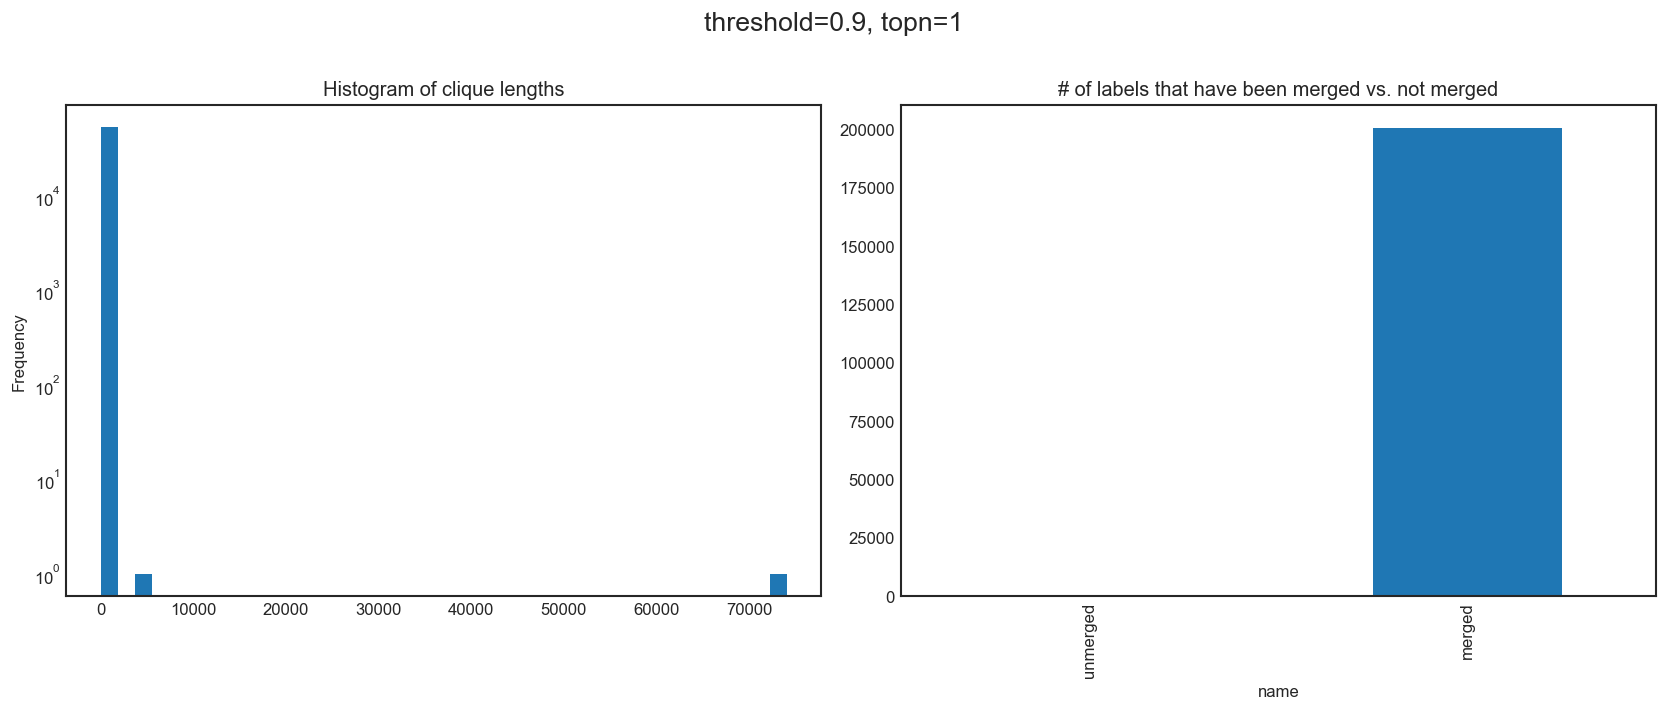

In [9]:
import coreference
for lookup_file in glob('data/embeddings/graph-embeddings/*.threshold-*.*.label-lookup.npy'):
    threshold, topn = get_treshold_and_topn_from_lookupfilename(lookup_file)
    with open(lookup_file, 'rb') as f:
        lookup = pickle.load(f)
    for key in lookup.values():
        if not isinstance(key, (str, int)):
            print("?")
            break
    fig, axes = coreference.plot_lookup_histogram(lookup=lookup, title = 'threshold={}, topn={}'.format(threshold, topn))
    plt.show()
    plt.close(fig)